In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages

sns.set_color_codes()
# sns.set_theme()
sns.set_context("paper")

In [2]:
import itertools
from info_salience.agreement import spearman_rank_correlation
import pandas as pd
import numpy as np

In [3]:
def pairwise_spearman(raters_a, raters_b=None):
    """
    calculates pairwise spearman rank correlation between two pools of raters
    raters_a and raters_b should be of shape (n_raters, n_items)
    """
    if raters_b is None:
        pairs = itertools.combinations(raters_a, r=2)
    else:
        assert raters_a.shape[1] == raters_b.shape[1]
        pairs = itertools.product(raters_a, raters_b)

    scores = []
    for ratings_a, ratings_b in pairs:
        score = spearman_rank_correlation(ratings_a, ratings_b)
        scores.append(score)
    return scores

In [4]:
def data_efficiency(dataset, model):
    df_baseline = pd.concat([
        pd.read_json(f'../output/{dataset}/{model}/discord-qa-nli/temperature0.3-{i}.json')
        for i in range(5)
    ])
    baseline = df_baseline.groupby('cluster_id')['summary_200w_nli_pred'].mean()


    fracs = []
    scores = []
    
    df = pd.read_json(f'../output/{dataset}/{model}/discord-qa-nli/temperature0.3-2.json')
    doc_ids = pd.Series(df['doc_id'].unique())
    for frac in np.linspace(0.05, 1, num=20):
        for i in range(5):
            sample_docs = doc_ids.sample(frac=frac)
            candidate = df[df['doc_id'].isin(sample_docs)].groupby('cluster_id')['summary_200w_nli_pred'].mean()
            score = pairwise_spearman(baseline.values.reshape(1,-1), candidate.values.reshape(1,-1))[0]
            fracs.append(frac)
            scores.append(score)

    df_scores = pd.DataFrame({
        'samples': fracs,
        'score': scores,
        'dataset': dataset
    })
    return df_scores

Text(0.0, 1.0, 'Data efficiency of LLM-observed: Correlation of salience estimated on\na document sample vs. salience estimated on all documents\nModel: Meta-Llama-3.1-70B-Instruct')

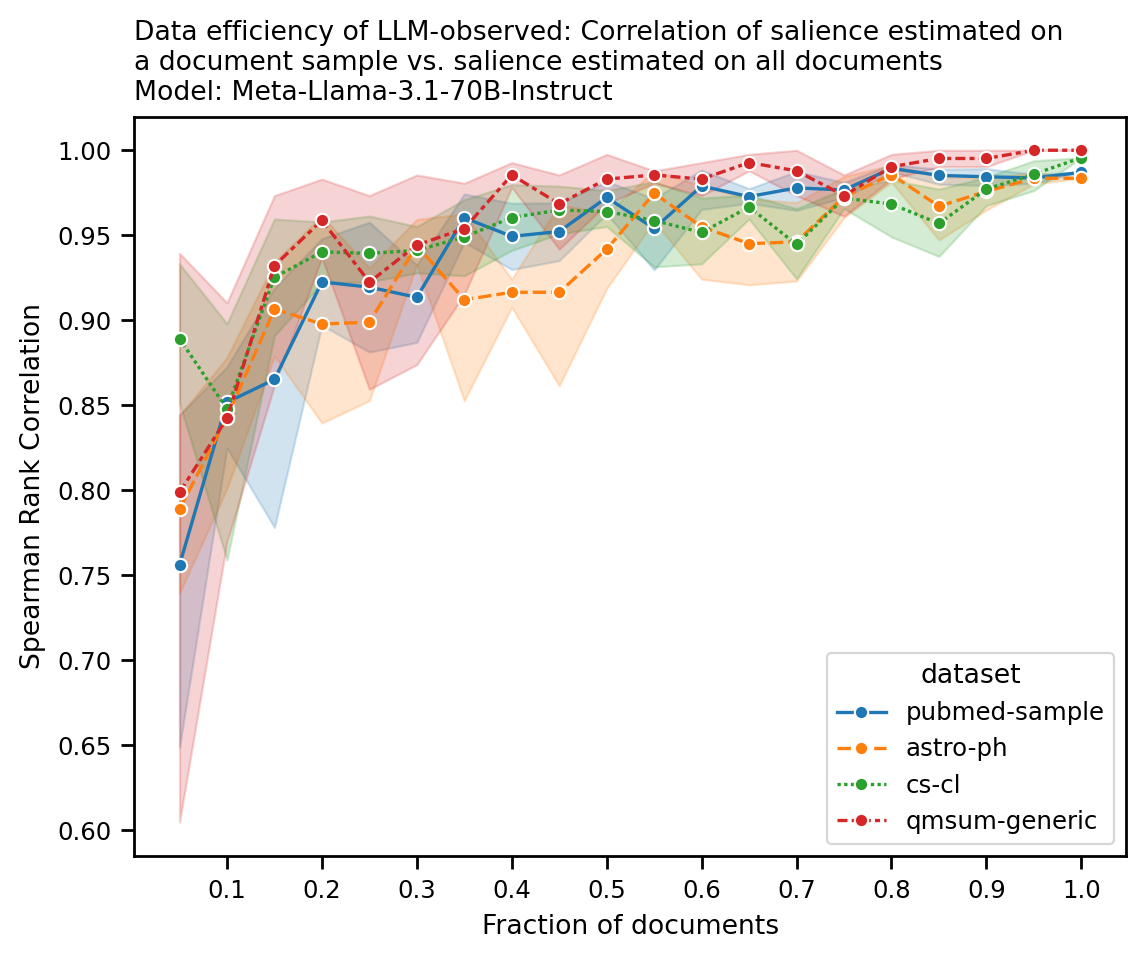

In [8]:
df_scores = pd.concat([data_efficiency(dataset, 'Meta-Llama-3.1-70B-Instruct') for dataset in ['pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic']])    

sns.lineplot(df_scores, x='samples', y='score', hue='dataset', style='dataset', marker='o')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Fraction of documents')
plt.ylabel('Spearman Rank Correlation')
plt.title('Data efficiency of LLM-observed: Correlation of salience estimated on\na document sample vs. salience estimated on all documents\nModel: Meta-Llama-3.1-70B-Instruct', ha='left', loc='left')
# plt.ylim([0,1.02])

Text(0.0, 1.0, 'Data efficiency of LLM-observed: Correlation of salience estimated on\na document sample vs. salience estimated on all documents\nModel: gpt-4o-mini-2024-07-18')

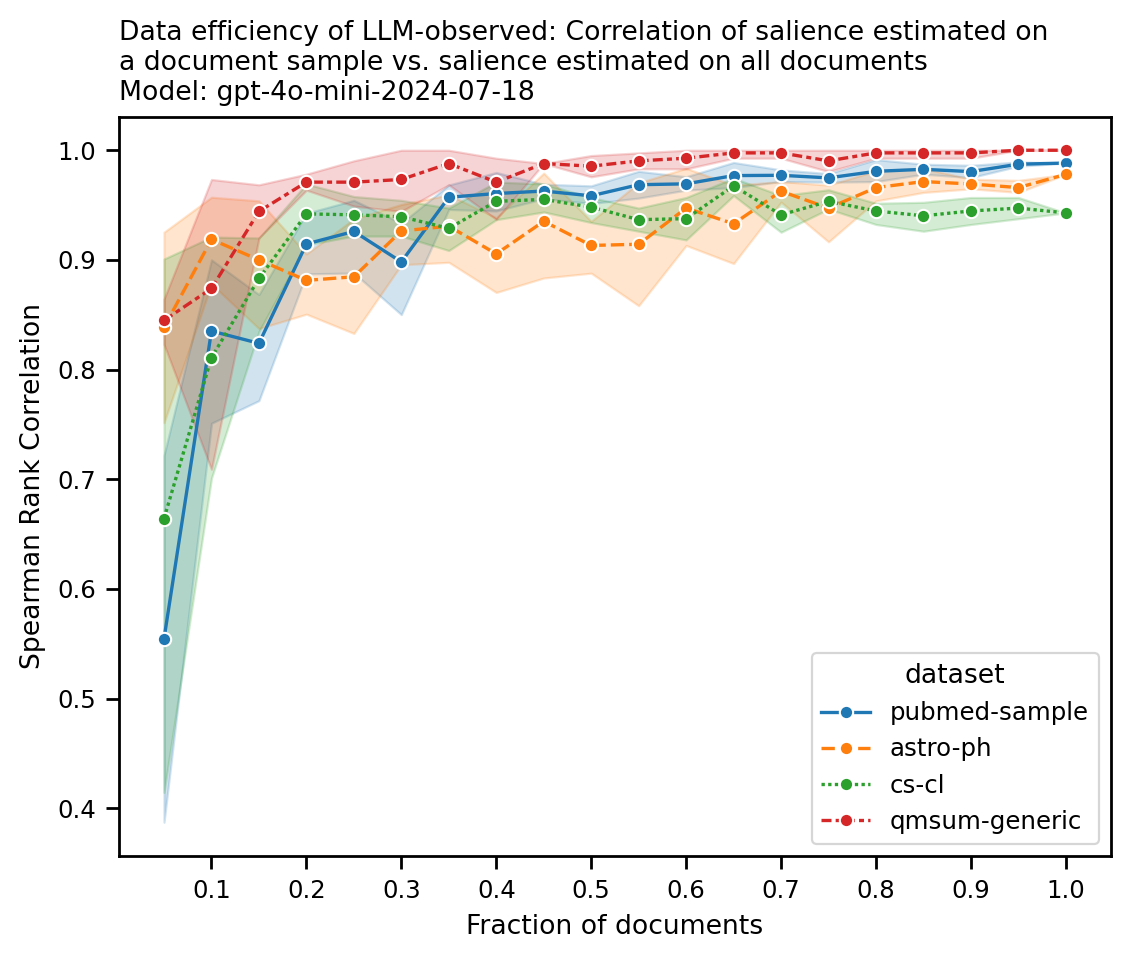

In [10]:
df_scores = pd.concat([data_efficiency(dataset, 'gpt-4o-mini-2024-07-18') for dataset in ['pubmed-sample', 'astro-ph', 'cs-cl', 'qmsum-generic']])    

sns.lineplot(df_scores, x='samples', y='score', hue='dataset', style='dataset', marker='o')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Fraction of documents')
plt.ylabel('Spearman Rank Correlation')
plt.title('Data efficiency of LLM-observed: Correlation of salience estimated on\na document sample vs. salience estimated on all documents\nModel: gpt-4o-mini-2024-07-18', ha='left', loc='left')
# plt.ylim([0,1.02])